In [18]:
# pip install ssrm_test

In [1]:
# Required Packages
import numpy as np
import pandas as pd
from scipy.stats import multinomial

from datetime import datetime, timedelta
from scipy import stats

from numpy import random
import datetime
from random import randint

from ssrm_test import ssrm_test
import matplotlib.pyplot as plt

# SRM_Test Class Documentation

## Overview
The SRM_Test class is designed to detect a Sample Ratio Mismatch (SRM) in a given dataset using the Sequential Sample Ratio Mismatch approach. It performs data preparation, calculates sequential p-values, identifies significant p-values, and visualizes the results. This class is particularly useful for analyzing datasets with multiple variants and assessing their statistical significance.

## Class Initialization

When initializing an instance of the SRM_Test class, the following key instance variables are set:

- DataFrame (df): The dataset containing experimental data.
- Variant Column Name (variant_col): The column name in the DataFrame that specifies the variants.
- Number of Variants (num_variants): The total number of variants in the dataset.
- Sequential p-values (p_values): A list to store calculated sequential p-values.
- Threshold Index (threshold_index): The index where the p-value first falls below the specified threshold.
- Expected Probabilities (p_0): The list of expected probabilities for each variant.
- P-value Threshold (threshold): The significance threshold for rejecting the null hypothesis.

These variables are essential for configuring the class and performing SRM detection accurately.

## Methods:

### prepare_data()
Purpose: Prepares the dataset by converting the variant column into a suitable format for the SSRM test.

Functionality:
- Checks for the existence of the variant column in the DataFrame.
- Applies one-hot encoding to the variant column, converting categorical data into a binary matrix.

Importance: Ensures that the data is correctly formatted for subsequent p-value calculations.

### calculate_p_values()
Purpose: Computes sequential p-values using the ssrm_test module.

Functionality:
- Verifies that the expected probabilities (p_0) are set and valid.
- Calculates p-values dynamically as more data is observed.

Importance: Provides a measure of the probability that observed data could occur under the null hypothesis, critical for SRM detection.

### find_threshold_index()
Purpose: Identifies the index where the p-value first drops below the specified threshold.

Functionality:
- Scans the list of sequential p-values.
- Finds the first instance where the p-value is below the pre-defined threshold (typically 0.05).

Importance: Helps in detecting significant p-values and potential SRMs efficiently.

### plot_p_values()
Purpose: Visualizes the sequential p-values and marks the threshold crossing point.

Functionality:
- Generates a plot showing the progression of p-values over time.
- Highlights the point where the p-value falls below the threshold.

Importance: Provides an intuitive visual representation of the p-value trends and aids in understanding the experiment’s progress.

### srm_test(df, variant_col, num_variants, p_0, threshold)
Purpose: Orchestrates the SRM detection process by integrating all necessary steps.

Parameters:
- df: The DataFrame containing the experimental data.
- variant_col: The column name specifying the variants.
- num_variants: The total number of variants.
- p_0: Expected probabilities for each variant.
- threshold: Significance threshold for p-value rejection.

Functionality:
- Calls prepare_data() to prepare the dataset.
- Calls calculate_p_values() to compute p-values.
- Calls find_threshold_index() to identify the threshold crossing point.
- Calls plot_p_values() to generate the visualization.

Importance: Provides a complete workflow for performing the SRM test, allowing flexibility and adaptability to different experimental setups.

Here we test the SRM_Test class on a sample data provided by our industrial partner Wise.

In [2]:
file_path = r'C:\Users\General\Documents\GitHub\tw-experimentation\data\test_data.csv'

# Read the CSV file into a pandas DataFrame
a = pd.read_csv(file_path)
a

T  conversion      revenue  pre_exp_revenue  num_actions  \
0     1           0     0.000000      1259.336092            0   
1     0           0     0.000000       184.145856            0   
2     0           0     0.000000       461.242410            0   
3     1           0     0.000000       215.445976            0   
4     1           0     0.000000       214.730544            0   
...  ..         ...          ...              ...          ...   
9995  0           1  3346.579443        55.610261            9   
9996  0           0     0.000000       627.234803            0   
9997  1           1   531.085381       179.223464           11   
9998  0           1   919.237492      1080.817780            9   
9999  2           1  2577.921546      2573.318650            9   

            trigger_dates currency country_of_origin segment_1 segment_2  \
0     2022-01-01 00:16:00      EUR                US       New    Active   
1     2022-01-02 19:02:00      USD                UK       Old      Rare   
2     2022-01-12 10:55:00      EUR               USD       Old     Usual   
3     2022-01-05 18:20:00      USD               USD       New    Active   
4     2022-01-15 23:38:00      EUR                UK       New      Rare   
...                   ...      ...               ...       ...       ...   
9995  2022-01-08 09:24:00      EUR                US       New    Active   
9996  2022-01-04 03:10:00      USD                US       Old     Usual   
9997  2022-01-05 09:11:00      GBP                UK       New     Usual   
9998  2022-01-16 10:51:00      GBP                UK       New    Active   
9999  2022-01-09 03:30:00      USD                UK       Old     Usual   

          segment_3  
0     10- transfers  
1     10- transfers  
2     10+ transfers  
3     10- transfers  
4     10- transfers  
...             ...  
9995  10- transfers  
9996  10- transfers  
9997  10+ transfers  
9998  10+ transfers  
9999  10- transfers  

[10000 rows x 11 columns]

In [3]:
class SRM_Test:
    def __init__(self):
        self.df = None
        self.variant_column = None
        self.num_variants = None
        self.pvals = None
        self.index_below_threshold = None
        self.p_0 = None
        self.threshold = None

    def prepare_data(self):
        """Prepare the data by one-hot encoding the variant column."""
        
        # Ensure the variant_column exists in the DataFrame
        if self.variant_column not in self.df.columns:
            raise ValueError(f"Column '{self.variant_column}' does not exist in the DataFrame.")
            
        unique_variants = self.df[self.variant_column].unique()
        
        variant_to_index = {variant: idx for idx, variant in enumerate(unique_variants)}
        
        # One-hot encode the variant column
        self.df['prepared'] = self.df[self.variant_column].apply(
            lambda x: [1 if i == variant_to_index[x] else 0 for i in range(self.num_variants)]
        )
        
        self.df_prepared = np.array(self.df['prepared'].to_list())

    def calculate_p_values(self):
        """Calculate sequential p-values using the provided ssrm_test module."""
        
        if self.p_0 is None:
            raise ValueError("p_0 is not set. Please provide a valid p_0 array.")
            
        self.pvals = ssrm_test.sequential_p_values(self.df_prepared, self.p_0)

    def find_threshold_index(self):
        """Find the first index where p-value goes below the threshold"""
        
        self.index_below_threshold = next((i for i, v in enumerate(self.pvals) if v < self.threshold), None)

    def plot_p_values(self):
        """Plot the sequential p-values."""
        
        fig = plt.figure()
        plt.plot(self.pvals)
        fig.suptitle("Sequential p-value for Testing SRM", fontsize=20)
        plt.xlabel("Visitor Count", fontsize=18)
        plt.ylabel("p-value", fontsize=16)
        plt.ylim(0, 1)
        plt.axhline(y=0.05, color='red', linestyle='--')

        if self.index_below_threshold is not None:
            plt.axvline(x=self.index_below_threshold, color='blue', linestyle='--')

        plt.show()

        if self.index_below_threshold is not None:
            print(f"The p-value first goes below 0.05 at visitor count {self.index_below_threshold}.")
        else:
            print("The p-value never goes below 0.05 in the given data.")

    def srm_test(self, df, variant_column, num_variants = None, p_0 = None, threshold = None):
        """
        Perform the SRM test.

        Parameters:
        df (pd.DataFrame): The input data.
        variant_column (str): The column name for variants.
        num_variants (int, optional): The number of variants.
        p_0 (list, optional): Expected probabilities for each variant.
        threshold (int, optional): The threshold for the null hypothesis to be rejected.
        """
        
        self.df = df
        self.variant_column = variant_column
        
        if num_variants is not None:
            self.num_variants = num_variants
        else:
            self.num_variants = len(self.df[self.variant_column].unique())
        
        if p_0 is not None:
            if len(p_0) != self.num_variants:
                raise ValueError(f"Length of p_0 ({len(p_0)}) does not match num_variants ({self.num_variants}).")
            if not np.isclose(sum(p_0), 1):
                raise ValueError(f"Sum of p_0 ({sum(p_0)}) does not equal 1.")
            self.p_0 = np.array(p_0)
        else:
            self.p_0 = np.full(self.num_variants, 1 / self.num_variants)

        self.threshold = threshold if threshold is not None else 0.05
        
        self.prepare_data()
        self.calculate_p_values()
        self.find_threshold_index()
        self.plot_p_values()

In [4]:
test = SRM_Test()

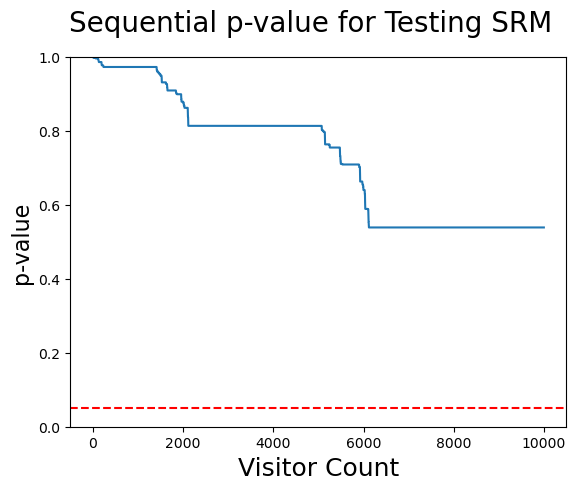

The p-value never goes below 0.05 in the given data.


In [5]:
test.srm_test(a, 'T')

Here we can see that the class effectively prepares the data, performs the SSRM test, and plots the results, allowing us to validate the performance of our proposed method against experimental data.

Our Industrial Partner, Wise provided us with three more supplementary datasets for us to test the performance of our class.

In [6]:
file_path2 = r'C:\Users\General\Desktop\CAPSTONE\Datasets'
# C:\Users\General\Desktop\MSc Data Science\CAPSTONE\Datasets

a_1 = pd.read_csv(file_path2 + '\\test1.csv')
a_2 = pd.read_csv(file_path2 + '\\test2.csv')
a_3 = pd.read_csv(file_path2 + '\\test3.csv')

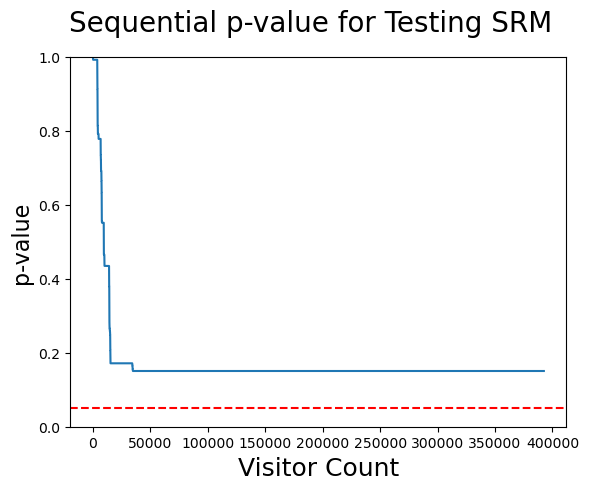

The p-value never goes below 0.05 in the given data.


In [7]:
test.srm_test(a_1, 'VARIANT')

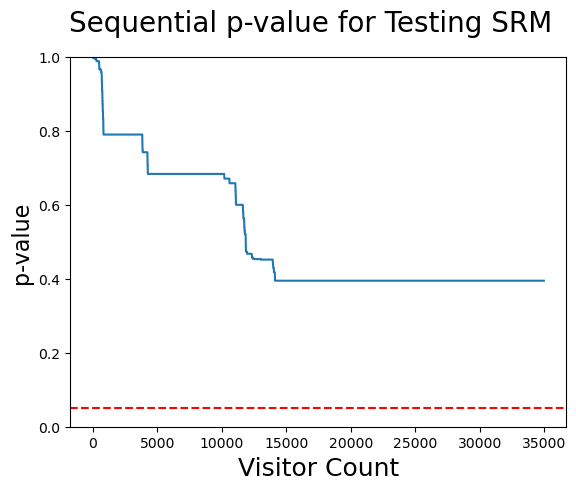

The p-value never goes below 0.05 in the given data.


In [8]:
test.srm_test(a_2, 'VARIANT', 2)

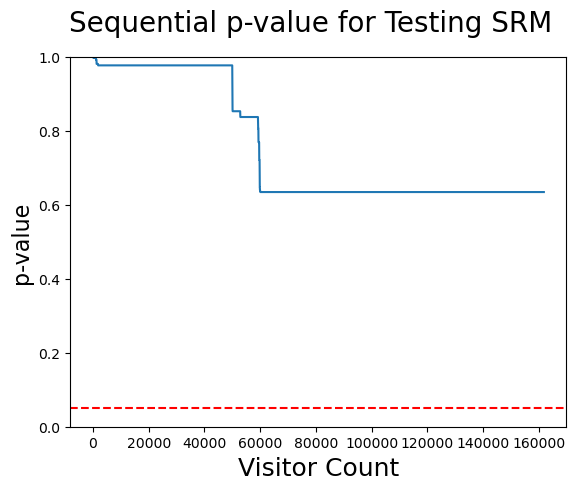

The p-value never goes below 0.05 in the given data.


In [9]:
test.srm_test(a_3, 'VARIANT')

We see again how the class is structured to handle the entire process from data preparation to plotting the results and works effectively.

We try creating some simulated data to check whether the class is able to detect an SRM within the data.

In [10]:
def variant_data(
    n,
    treatment_share,
    baseline_conversion: float = 0.5,
    treatment_effect_conversion: float = 0.1,
    seed: int = 1,
) -> pd.DataFrame:
    
    treatment_expectation = baseline_conversion + treatment_effect_conversion
    if treatment_expectation > 1 or treatment_expectation < 0:
        raise Exception("Conversion probability must be between 0 and 1 for treatment.")

    np.random.seed(seed)
    variant = random.binomial(n=1, p=treatment_share, size=n)

    df = pd.DataFrame(
        {
            "T": variant,
        }
    )
    return df

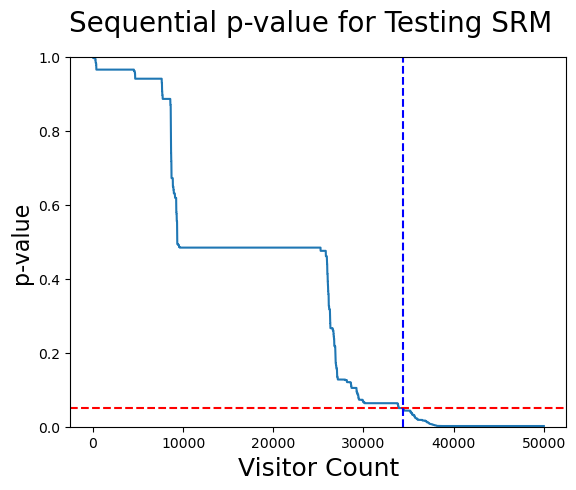

The p-value first goes below 0.05 at visitor count 34386.


In [11]:
x_1 = variant_data(50000, 0.49)
test.srm_test(x_1, 'T')

The class is able to detect the SRM and also provides us with the count at which the SRM was detected. The sequential SRM test maintained p-values above the significance threshold for an extended period helping us reduce the risk of a false positive.

### Extra Dataset Used for Experimentation

To experiment with and improve the SRM_Test class, I downloaded an A/B testing dataset from Kaggle. The dataset used is titled "Mobile Games A/B Testing" and can be accessed at the following link: https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats.

### Dataset Details

Source: Kaggle Mobile Games A/B Testing Dataset
Description: This dataset contains information related to A/B testing experiments conducted on a mobile game, including user interactions and variant assignments.

In [12]:
test_data = pd.read_csv(file_path2 + '\\cookie_cats.csv')

In [13]:
test_data

userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3        False        False
1          337  gate_30              38         True        False
2          377  gate_40             165         True        False
3          483  gate_40               1        False        False
4          488  gate_40             179         True         True
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_40              51         True        False
90188  9999861  gate_40              16        False        False

[90189 rows x 5 columns]

### Modifications and Experimentation
In this experiment, the dataset includes values in text form for the control and treatment groups, rather than binary values (0 and 1). The SRM_Test class was adapted to handle this textual data by converting the text-based variant indicators into a suitable format for the SSRM test. Specifically:

- Textual Data Handling: The prepare_data() method was enhanced to process textual values for the control and treatment groups. The variant column, which initially contained text labels, was converted into binary format through one-hot encoding.
- SSRM Test Application: After converting the textual values into a binary matrix, the calculate_p_values() method was used to perform the SSRM test on this data, ensuring that the class could handle different data formats effectively.

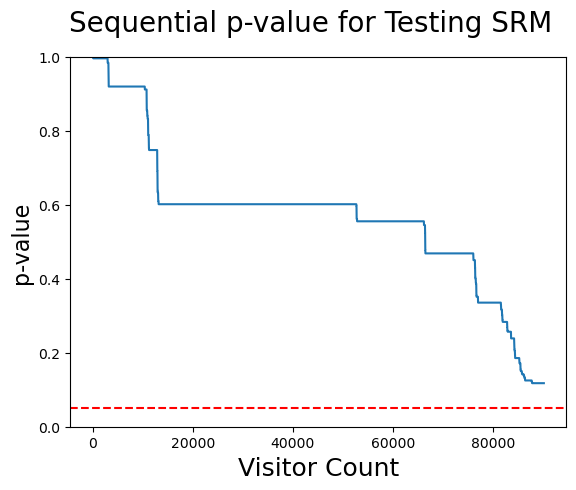

The p-value never goes below 0.05 in the given data.


In [14]:
test.srm_test(test_data, 'version')

These modifications allowed for a more versatile application of the SRM_Test class and improved its robustness in handling real-world A/B testing datasets with varying data formats.

## Conclusion
In this project, the SRM_Test class was developed and tested using various datasets provided to us from our Industrial Partner - Wise and an A/B testing dataset from Kaggle. 
The class effectively utilized the ssrm_test module to compute sequential p-values and detect Sample Ratio Mismatch (SRM) in the data. By integrating data preparation, p-value calculation, and visualization, the SRM_Test class demonstrated its capability to handle both binary and textual data formats, providing valuable insights into the significance of variants in the dataset.

Overall, the effective application of the ssrm_test module within the class facilitated accurate SRM detection, offering a robust tool for analyzing experimental data.

## Future Work
Several areas for future enhancement and application of the SRM_Test class include:

- Real-Time Data Analysis: Adapting the class for real-time data streaming could enable dynamic SRM testing as new data arrives. This would involve optimizing the calculate_p_values() method for performance and integrating with data pipelines.

- Multi-Group SRM Analysis: Extending the class to handle more complex experimental designs involving multiple treatment groups, controls, or segments could provide a more granular analysis of SRMs. This would involve adapting the data preparation and p-value calculation methods to account for additional layers of segmentation and interactions.

- Advanced Visualization: Implementing more sophisticated visualization options could provide deeper insights into p-value trends and statistical significance, enhancing the interpretability of results and the cause for the SRM